### Globals

In [1]:
%matplotlib inline
import os
import glob
import subprocess
import sys
import json
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

rootdir = '/home/preclineu/ramcir/Desktop/Diffusion/'
qcdir = os.path.join(rootdir, 'qc', 'dMRI')

if os.path.exists(qcdir) == False:
    os.mkdir(os.path.join(rootdir, 'qc', 'dMRI'))
else: pass

cluster_log_dir = '/home/preclineu/ramcir/DCCN/TorqueLogs'

cmd_qsub_base = ['/home/preclineu/ramcir/DCCN/Scripts/SubmitToCluster.py',
                 '-length', '102400',
                 '-memory', '2gb',
                 '-logfiledir', cluster_log_dir
                ]

# get a list of subjects to process
sub_dirs = sorted(glob.glob(os.path.join(rootdir,'subjects','*')))
print('Found', len(sub_dirs), 'subjects to process')

Found 20 subjects to process


### Sort subjects

In [3]:
sub_no_dmri = []
sub_no_eddy = []
sub_ready = []
sub_complete = []

# Control the number of subjects
sdirs = sub_dirs[0:]

for s in sdirs:
    subid = os.path.splitext(os.path.basename(s))[0]

    dmridir = os.path.join(s, 'dMRI', 'dMRI')
    quaddir = os.path.join(dmridir, 'data.qc')  
    eddyfile = os.path.join(dmridir, 'data.eddy_parameters')
    
    try:
        #Check if dMRI data is avalable
        if os.path.exists(dmridir) == False:  
#             print(subid,' dMRI data not found.')
            sub_no_dmri.append(subid)
        else: 
            #Check if EDDY files are available
            if os.path.exists(eddyfile) == False:
#                 print(subid,' EDDY data not found.')
                sub_no_eddy.append(subid)
            else:  
                #Check if quad has already been run
                if os.path.exists(quaddir) == True:
#                     print(subid,' QC already done.') 
                    sub_complete.append(s)
                else:
#                     print(subid,' is ready for QC') 
                    sub_ready.append(s)
    except:
        print(subid, ' ignored due to', sys.exc_info()[0], '. Continuing with the next subject.')
        
print('Found', len(sub_no_dmri), 'subjects who are missing dMRI data')
print('Found', len(sub_no_eddy), 'subjects who are missing eddy')
print('Found', len(sub_ready), 'subjects ready to process')
print('Found', len(sub_complete), 'subjects already processed')


Found 1 subjects who are missing dMRI data
Found 1 subjects who are missing eddy
Found 1 subjects ready to process
Found 17 subjects already processed


#### Save arrays of sorted subs

In [3]:
import numpy as np
no_dmri_array = os.path.join(qcdir,'sub_no_dmri')
no_eddy_array = os.path.join(qcdir,'sub_no_eddy')
sub_complete_array = os.path.join(qcdir,'sub_qc_dmri')
np.save(no_dmri_array, sub_no_dmri)
np.save(no_eddy_array, sub_no_eddy)
np.save(sub_complete_array, sub_complete)

### Run QUAD

In [4]:
quad_paths = os.path.join(qcdir,'quad_paths.txt')
open(quad_paths, 'a').close()

In [5]:
for s in sub_ready[0:]:  
    subid = os.path.splitext(os.path.basename(s))[0]
    dmridir = os.path.join(s, 'dMRI', 'dMRI')
    mask_dir = os.path.join(dmridir,'nodif_mask.nii.gz')
    acqparam_file = os.path.join(dmridir, 'acqparam.txt')
    idx_file = os.path.join(dmridir, 'index.txt')
    quaddir = os.path.join(dmridir, 'data.qc')  

    
    if os.path.exists(quaddir) == True:
        print(subid,' QC already done. Doing nothing')
    else:
        print(subid,' QUAD running')
        #Create symbolic link for data_ud with the name data
        #This is necessary for running 'quad' since all other eddy outputs are called data.eddy.
        os.chdir(dmridir)
        if os.path.islink('./data.nii.gz') == False:
            os.symlink('./data_ud.nii.gz', './data.nii.gz')
        else: pass

        #Create aquision parameters file and index file
        #The acquisition parameters file is based on dataset acq documentation
        #i.e. AP dir = 0 1 0, PA dir = 0 -1 0, Echo spacing = 0.67 ms, EPI factor = 104 (for UKB)
        if os.path.exists(acqparam_file) == False:
            with open(os.path.join(dmridir,'acqparams.txt'), 'w') as acqparams:
                acqparams.write('0 1 0 0.069\n0 -1 0 0.069')
        else:pass

        #The index file indicated the direction in which each volume was aquired (based on aqcparams.txt)
        #count number of volumes present in data
        if os.path.exists(idx_file) == False:
            with open(os.path.join(dmridir,'bvals'), 'r') as bvals:
                data = bvals.read()
                vols = data.split()
                no_vols = len(vols)
            with open(os.path.join(dmridir,'index.txt'), 'w') as index:
                for vol in range(0,no_vols):    
                    index.write('1 ')
        else:pass
    
        #Write command for creating the b0 mask 
        
        fslroi_cmd = ['fslroi ' + dmridir + '/data.nii.gz',
                           dmridir + '/b0_data.nii.gz' ' 0 1']
        fslbet_cmd = ['bet ' + dmridir + '/b0_data.nii.gz',
                           dmridir + '/nodif' ' -f 0.1 -g 0 -m -n']
    
        #Write command for running QUAD      
        quad_cmd = ['eddy_quad ' + dmridir + '/data',
                     '-idx ' + dmridir + '/index.txt',
                     '-par ' + dmridir + '/acqparams.txt',
                     '-m ' + dmridir + '/nodif_mask', 
                     '-b ' + dmridir + '/bvals ' 
                     '-g '  + dmridir + '/bvecs']
        
        #Add the path of the qc folder to txt file (will be needed for SQUAD)
        append_cmd = ['echo -e "', quaddir, '" >> ', quad_paths ]

        #Join comands and sumbit process
        proc_cmd = '"%s"' % str(' '.join(fslroi_cmd) + ' && ' + ' '.join(fslbet_cmd) + ' && ' + ' '.join(quad_cmd) + ' && ' + ''.join(append_cmd))
        cmd_qsub = cmd_qsub_base + ['-name', 'UKB_quad_' + subid ,'-command', proc_cmd]     
        subprocess.run(' '.join(cmd_qsub), shell=True)
             

1326726  QUAD running
This is your qsub command: qsub -l walltime=102400,mem=2gb,nodes=1:ppn=1,epilogue=/home/mrstats/maamen/DCCN/Scripts/Torque/epilogue.sh -q batch -N UKB_quad_1326726 -e /home/preclineu/ramcir/DCCN/TorqueLogs -o /home/preclineu/ramcir/DCCN/TorqueLogs -M ramcir -m n -b y -r y <<EOF
fslroi /home/preclineu/ramcir/Desktop/Diffusion/subjects/1326726/dMRI/dMRI/data.nii.gz /home/preclineu/ramcir/Desktop/Diffusion/subjects/1326726/dMRI/dMRI/b0_data.nii.gz 0 1 && bet /home/preclineu/ramcir/Desktop/Diffusion/subjects/1326726/dMRI/dMRI/b0_data.nii.gz /home/preclineu/ramcir/Desktop/Diffusion/subjects/1326726/dMRI/dMRI/nodif -f 0.1 -g 0 -m -n && eddy_quad /home/preclineu/ramcir/Desktop/Diffusion/subjects/1326726/dMRI/dMRI/data -idx /home/preclineu/ramcir/Desktop/Diffusion/subjects/1326726/dMRI/dMRI/index.txt -par /home/preclineu/ramcir/Desktop/Diffusion/subjects/1326726/dMRI/dMRI/acqparams.txt -m /home/preclineu/ramcir/Desktop/Diffusion/subjects/1326726/dMRI/dMRI/nodif_mask -b /h

### Run SQUAD
Only run after all subjects have quad

In [45]:
squad_cmd = 'eddy_squad'
quad_folders = os.path.join(qcdir,'quad_paths.txt')
prep_cmd = squad_cmd + ' ' + os.path.join(qcdir,'quad_paths.txt') + ' -o ' + os.path.join(qcdir,'squad')
print(prep_cmd)
subprocess.run(prep_cmd, shell = True)        

eddy_squad /project_freenas/3022017.02/UKB/qc/dMRI/quad_paths.txt -o /project_freenas/3022017.02/UKB/qc/dMRI/squad


CompletedProcess(args='eddy_squad /project_freenas/3022017.02/UKB/qc/dMRI/quad_paths.txt -o /project_freenas/3022017.02/UKB/qc/dMRI/squad', returncode=0)

### Run slicesdir
To check the binary mask

In [ ]:
string = ""

#this is where the slicesdir will be saved
os.chdir(qcdir)

#append the path to b0_data and nodif_mask for each sub
for s in sub_complete[0:9]:
    dmridir = os.path.join(s, 'dMRI', 'dMRI')
    string+=str(dmridir + '/b0_data.nii.gz ' + dmridir + '/nodif_mask.nii.gz' + ' ')

#prep and run the slicesdir command
slices_cmd = 'slicesdir'
prep_cmd = slices_cmd + ' -o ' + string
subprocess.run(prep_cmd, shell = True)

#### Check if any paths are missing from the text file

In [44]:
if os.path.exists(quad_paths) == True:
    with open(quad_paths, 'r') as paths:
        n_paths = len(paths.readlines())
    print('There are',n_paths,'paths in the text file.')
else:
    print('The paths text file doesnot exist')
print(len(sub_complete)-n_paths, 'paths are missing.')

There are 23158 paths in the text file.
0 paths are missing.


#### Add the missing paths to the text file

In [43]:
missed_subs = []
quad_paths = os.path.join(qcdir,'quad_paths.txt')
open(quad_paths, 'a').close()
for s in sub_complete[0:]: 
    dmridir = os.path.join(s, 'dMRI', 'dMRI')
    quaddir = os.path.join(dmridir, 'data.qc') 
    with open(quad_paths, 'r') as f:
        if quaddir in f.read():
             continue
        else:
            with open(quad_paths, 'a') as f:
                missed_subs.append(s)
                f.write(quaddir + '\n')
print(len(missed_subs), 'paths were added.')

0 paths were added.


In [29]:
df_fin = pd.DataFrame(columns = ['Avg x tr','Avg y tr','Avg z tr','Avg x rot','Avg y rot','Avg z rot','Std EC x ','Std EC y','Std EC z', 'Outliers b = 1000','Outliers b = 1997', 'Outliers PE dir (0, 1, 0)','Avg abs motion','Avg rel motion','Total outliers'])
for s in sub_complete[0:]: 
    subid = os.path.splitext(os.path.basename(s))[0]
    dmridir = os.path.join(s, 'dMRI', 'dMRI')
    quaddir = os.path.join(dmridir, 'data.qc')
    jsonfile = os.path.join(quaddir, 'qc.json')
    with open(jsonfile, 'r') as f:
        data = json.loads(f.read())
    df1 = pd.json_normalize(data, record_path = ['qc_params_avg'], meta = ['qc_mot_abs', 'qc_mot_rel', 'qc_outliers_tot'  ])
    df2 = pd.json_normalize(data, record_path = ['qc_outliers_b'])
    df3 = pd.json_normalize(data, record_path = ['qc_outliers_pe'])
    df_frames = [df1, df2, df3]
    df_sub = pd.concat(df_frames)
    qc_mot_abs = df_sub.iloc[0,1]
    qc_mot_rel = df_sub.iloc[0,2]
    qc_outliers_tot = df_sub.iloc[0,3]
    df_sub = df_sub.transpose()
    df_sub = df_sub.drop(index= ['qc_mot_abs', 'qc_mot_rel', 'qc_outliers_tot'])
    df_sub['qc_mot_abs'], df_sub['qc_mot_rel'], df_sub['qc_outliers_tot'] = [qc_mot_abs, qc_mot_rel, qc_outliers_tot] 
    df_sub.columns = ['Avg x tr','Avg y tr','Avg z tr','Avg x rot','Avg y rot','Avg z rot','Std EC x ','Std EC y','Std EC z', 'Outliers b = 1000','Outliers b = 1997', 'Outliers PE dir (0, 1, 0)','Avg abs motion','Avg rel motion','Total outliers']
    df_sub.index = [subid]
    df_fin = pd.concat([df_fin, df_sub])
display(df_sub)
display(df_fin)

,Avg x tr,Avg y tr,Avg z tr,Avg x rot,Avg y rot,Avg z rot,Std EC x,Std EC y,Std EC z,Outliers b = 1000,Outliers b = 1997,"Outliers PE dir (0, 1, 0)",Avg abs motion,Avg rel motion,Total outliers
6025069,-0.023961,-0.146817,0.105116,-0.000316,-0.004077,0.007456,0.098796,0.137724,0.238447,1.111111,0.0,0.529101,1.94,2.1,0.555556


,Avg x tr,Avg y tr,Avg z tr,Avg x rot,Avg y rot,Avg z rot,Std EC x,Std EC y,Std EC z,Outliers b = 1000,Outliers b = 1997,"Outliers PE dir (0, 1, 0)",Avg abs motion,Avg rel motion,Total outliers
1000432,0.067655,-0.939196,0.114672,-0.005516,-0.000493,0.002742,0.06272,0.058086,0.270621,2.472222,1.611111,1.944444,1.17,0.78,2.041667
1000853,0.017003,-0.585111,-0.34155,0.014469,0.00039,0.000271,0.076919,0.100986,0.252164,0.75,0.111111,0.410053,2.21,2.21,0.430556
1000871,0.089933,0.25977,-0.088388,0.002289,-0.00385,0.002406,0.079946,0.09907,0.320405,1.138889,0.083333,0.582011,0.66,0.72,0.611111
1000910,-0.036212,-1.11116,-0.109127,0.002199,0.001733,-0.000738,0.08531,0.119553,0.267191,0.888889,0.0,0.42328,2.21,2.28,0.444444
1001309,0.02974,0.262508,-0.068946,-0.001847,-0.001499,0.000386,0.097156,0.166894,0.359241,1.416667,0.111111,0.727513,0.75,0.95,0.763889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6024203,0.101807,-0.603691,0.224198,0.001211,-0.004055,0.001184,0.064395,0.050533,0.217613,0.694444,0.055556,0.357143,1.01,0.96,0.375
6024607,0.016293,-0.982952,-0.039073,0.001267,0.003334,0.001799,0.064279,0.084206,0.117544,0.972222,0.138889,0.529101,1.21,1.1,0.555556
6024836,0.080954,-1.255294,0.07345,-0.001774,-0.000696,0.000231,0.101629,0.32277,0.23502,0.5,0.0,0.238095,1.6,1.54,0.25
6025056,-0.02552,-0.434727,-0.323077,0.002625,0.004309,0.003158,0.085053,0.063911,0.196396,0.972222,0.027778,0.47619,1.87,2.07,0.5


In [32]:
df_fin.to_pickle("./quad_metrics_ukb.pkl")

In [ ]:
plt.hist(df_fin['Avg x tr'], bins = 1000)

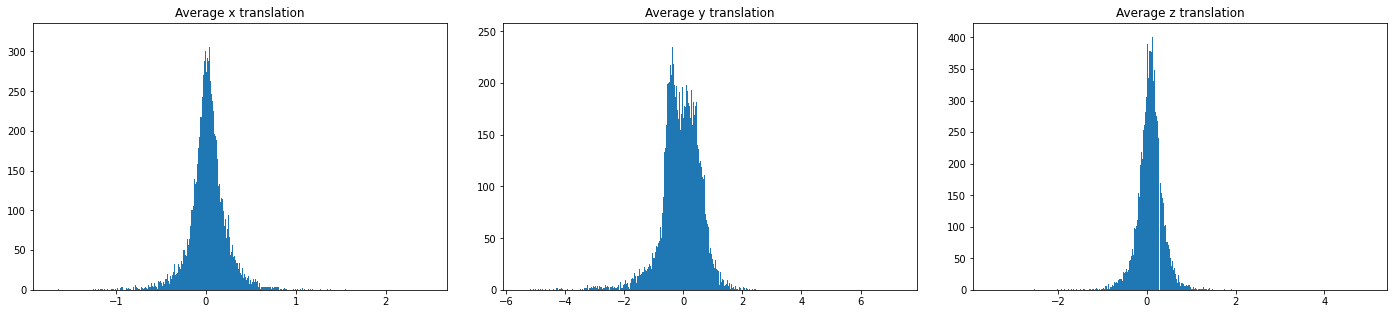

In [40]:
fig1 = plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
plt.hist(df_fin['Avg x tr'], bins = 1000)
plt.title('Average x translation')

plt.subplot(1,3,2)
plt.hist(df_fin['Avg y tr'], bins = 1000)
plt.title('Average y translation')

plt.subplot(1,3,3)
plt.hist(df_fin['Avg z tr'], bins = 1000)
plt.title('Average z translation')

fig1.tight_layout(pad = 3)
plt.show()

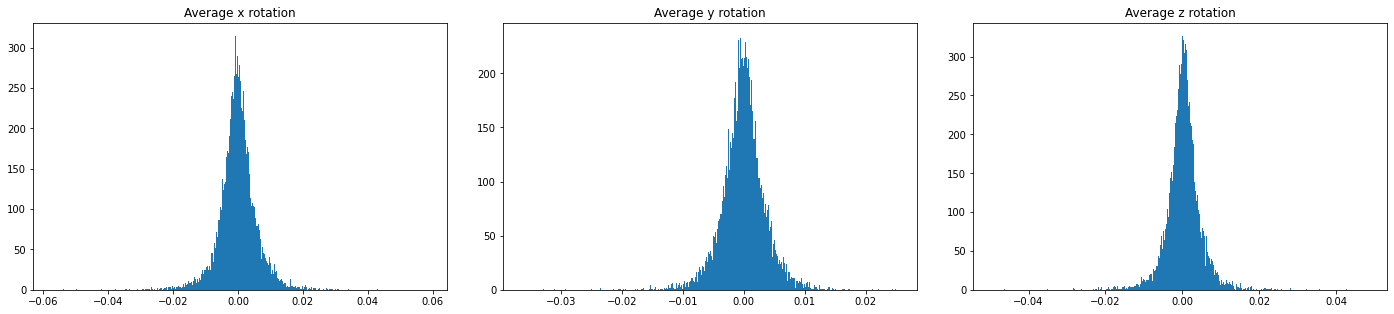

In [41]:
fig1 = plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
plt.hist(df_fin['Avg x rot'], bins = 1000)
plt.title('Average x rotation')

plt.subplot(1,3,2)
plt.hist(df_fin['Avg y rot'], bins = 1000)
plt.title('Average y rotation')

plt.subplot(1,3,3)
plt.hist(df_fin['Avg z rot'], bins = 1000)
plt.title('Average z rotation')

fig1.tight_layout(pad = 3)
plt.show()

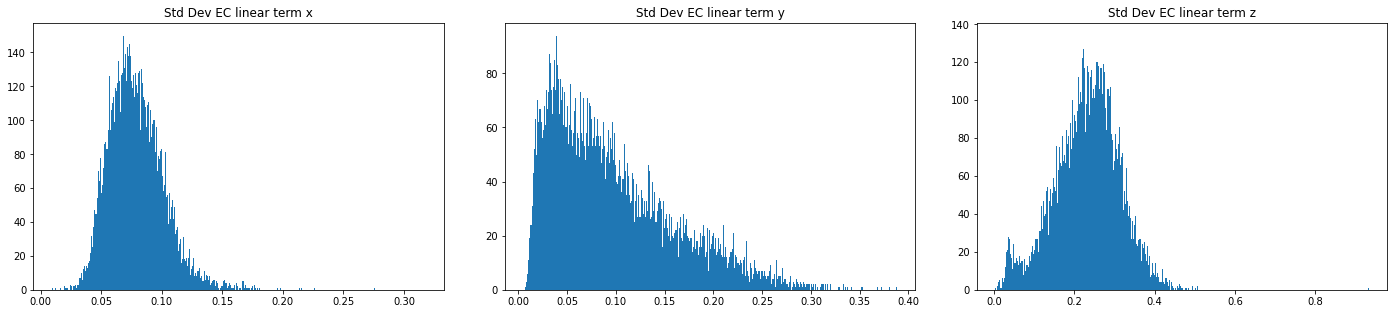

In [43]:
fig1 = plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
plt.hist(df_fin['Std EC x '], bins = 1000)
plt.title('Std Dev EC linear term x')

plt.subplot(1,3,2)
plt.hist(df_fin['Std EC y'], bins = 1000)
plt.title('Std Dev EC linear term y')

plt.subplot(1,3,3)
plt.hist(df_fin['Std EC z'], bins = 1000)
plt.title('Std Dev EC linear term z')

fig1.tight_layout(pad = 3)
plt.show()

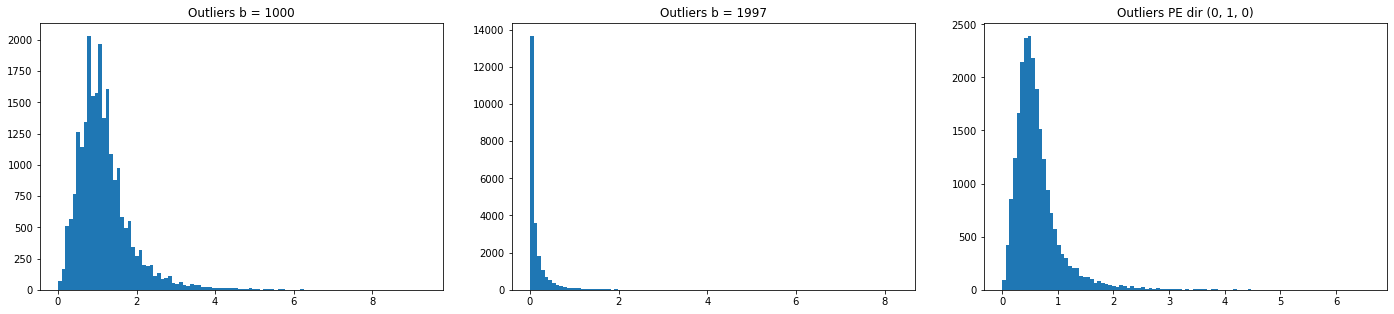

In [45]:
fig1 = plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
plt.hist(df_fin['Outliers b = 1000'], bins = 100)
plt.title('Outliers b = 1000')

plt.subplot(1,3,2)
plt.hist(df_fin['Outliers b = 1997'], bins = 100)
plt.title('Outliers b = 1997')

plt.subplot(1,3,3)
plt.hist(df_fin['Outliers PE dir (0, 1, 0)'], bins = 100)
plt.title('Outliers PE dir (0, 1, 0)')

fig1.tight_layout(pad = 3)
plt.show()

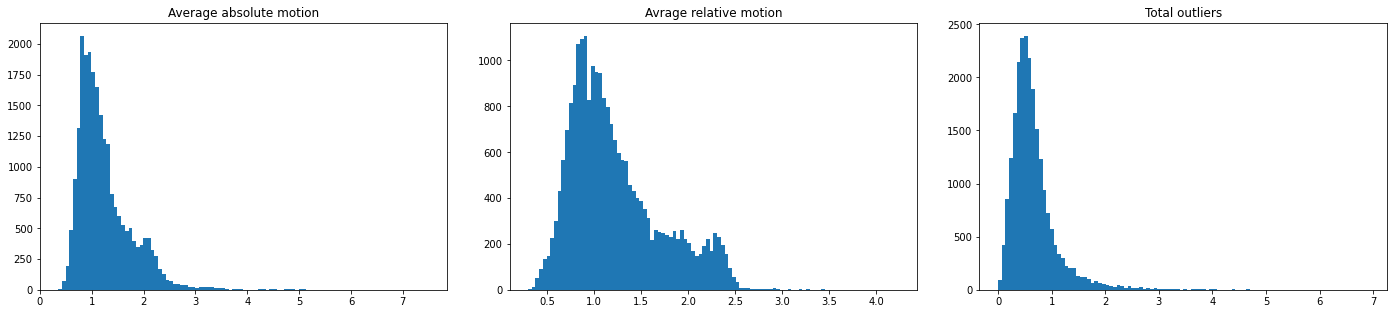

In [46]:
fig1 = plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
plt.hist(df_fin['Avg abs motion'], bins = 100)
plt.title('Average absolute motion')

plt.subplot(1,3,2)
plt.hist(df_fin['Avg rel motion'], bins = 100)
plt.title('Avrage relative motion')

plt.subplot(1,3,3)
plt.hist(df_fin['Total outliers'], bins = 100)
plt.title('Total outliers')

fig1.tight_layout(pad = 3)
plt.show()